In [1]:
# Install Java (required by Spark)
!apt-get update
!apt-get install openjdk-11-jdk -y

# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Extract Spark
!tar xf spark-3.4.1-bin-hadoop3.tgz

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Add Spark to system path
!pip install -q findspark
import findspark
findspark.init()


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,927 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,720 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901

In [2]:
!pip install pyspark
from pyspark.sql import SparkSession
import shutil, time, os

# Start Spark session
spark = SparkSession.builder.appName("StockStreaming").getOrCreate()

# Create streaming directories
for stock in ['META', 'GOOG', 'AMZN']:
    os.makedirs(f"{stock}Dir", exist_ok=True)

# Load static CSVs
meta = spark.read.csv("META.csv", header=True, inferSchema=True)
goog = spark.read.csv("GOOG.csv", header=True, inferSchema=True)
amzn = spark.read.csv("AMZN.csv", header=True, inferSchema=True)


In [3]:
# Set up readStream for each stock
meta_stream = spark.readStream.schema(meta.schema).csv("METADir/")
goog_stream = spark.readStream.schema(goog.schema).csv("GOOGDir/")
amzn_stream = spark.readStream.schema(amzn.schema).csv("AMZNDir/")

# Register as temp tables
meta_query = meta_stream.writeStream.queryName("meta_table").format("memory").outputMode("append").start()
goog_query = goog_stream.writeStream.queryName("goog_table").format("memory").outputMode("append").start()
amzn_query = amzn_stream.writeStream.queryName("amzn_table").format("memory").outputMode("append").start()


In [ ]:
# import shutil
# for stock in ['META', 'GOOG', 'AMZN']:
#     shutil.rmtree(f"{stock}Dir", ignore_errors=True)


In [4]:
for i in range(10):
    for stock, df in zip(['META', 'GOOG', 'AMZN'], [meta, goog, amzn]):
        df.limit(100).coalesce(1).write.mode("append").option("header", "true").csv(f"{stock}Dir")

    print(f"Iteration {i+1}: Showing streaming data")
    spark.sql("SELECT 'META' as stock, COUNT(*) as rows FROM meta_table").show()
    spark.sql("SELECT 'GOOG' as stock, COUNT(*) as rows FROM goog_table").show()
    spark.sql("SELECT 'AMZN' as stock, COUNT(*) as rows FROM amzn_table").show()

    time.sleep(5)


Iteration 1: Showing streaming data
+-----+----+
|stock|rows|
+-----+----+
| META| 101|
+-----+----+

+-----+----+
|stock|rows|
+-----+----+
| GOOG| 101|
+-----+----+

+-----+----+
|stock|rows|
+-----+----+
| AMZN| 101|
+-----+----+

Iteration 2: Showing streaming data
+-----+----+
|stock|rows|
+-----+----+
| META| 202|
+-----+----+

+-----+----+
|stock|rows|
+-----+----+
| GOOG| 202|
+-----+----+

+-----+----+
|stock|rows|
+-----+----+
| AMZN| 202|
+-----+----+

Iteration 3: Showing streaming data
+-----+----+
|stock|rows|
+-----+----+
| META| 303|
+-----+----+

+-----+----+
|stock|rows|
+-----+----+
| GOOG| 303|
+-----+----+

+-----+----+
|stock|rows|
+-----+----+
| AMZN| 303|
+-----+----+

Iteration 4: Showing streaming data
+-----+----+
|stock|rows|
+-----+----+
| META| 404|
+-----+----+

+-----+----+
|stock|rows|
+-----+----+
| GOOG| 404|
+-----+----+

+-----+----+
|stock|rows|
+-----+----+
| AMZN| 303|
+-----+----+

Iteration 5: Showing streaming data
+-----+----+
|stock|rows|
+-

In [5]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, Imputer

def train_and_select_best_model(df, stock):
    print(f"\n🔧 Training models for {stock}...")

    # Step 1: Impute missing values
    imputer = Imputer(strategy="mean", inputCols=["Open", "High", "Low", "Volume"],
                      outputCols=["Open", "High", "Low", "Volume"])
    df_imputed = imputer.fit(df).transform(df)

    # Step 2: Assemble features
    assembler = VectorAssembler(inputCols=["Open", "High", "Low", "Volume"], outputCol="features")
    data = assembler.transform(df_imputed).select("features", df_imputed["Close"].alias("label"))

    # Step 3: Split for training & evaluation
    train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

    models = {
        "LinearRegression": LinearRegression(featuresCol="features", labelCol="label"),
        "DecisionTree": DecisionTreeRegressor(featuresCol="features", labelCol="label"),
        "RandomForest": RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=20)
    }

    evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

    best_model = None
    best_rmse = float("inf")
    best_name = ""

    for name, model in models.items():
        print(f"Training {name} for {stock}...")
        fitted_model = model.fit(train_data)
        predictions = fitted_model.transform(test_data)

        rmse = evaluator_rmse.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)

        print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = fitted_model
            best_name = name

    print(f"✅ Best model for {stock}: {best_name} (RMSE: {best_rmse:.2f})")
    best_model.write().overwrite().save(f"{stock}_model")

    return best_name


In [6]:
meta_best = train_and_select_best_model(meta, "META")
goog_best = train_and_select_best_model(goog, "GOOG")
amzn_best = train_and_select_best_model(amzn, "AMZN")



🔧 Training models for META...
Training LinearRegression for META...
LinearRegression - RMSE: 0.98, MAE: 0.70, R²: 0.999
Training DecisionTree for META...
DecisionTree - RMSE: 2.61, MAE: 1.79, R²: 0.995
Training RandomForest for META...
RandomForest - RMSE: 1.89, MAE: 1.42, R²: 0.998
✅ Best model for META: LinearRegression (RMSE: 0.98)

🔧 Training models for GOOG...
Training LinearRegression for GOOG...
LinearRegression - RMSE: 0.21, MAE: 0.16, R²: 1.000
Training DecisionTree for GOOG...
DecisionTree - RMSE: 0.69, MAE: 0.46, R²: 0.996
Training RandomForest for GOOG...
RandomForest - RMSE: 0.57, MAE: 0.40, R²: 0.998
✅ Best model for GOOG: LinearRegression (RMSE: 0.21)

🔧 Training models for AMZN...
Training LinearRegression for AMZN...
LinearRegression - RMSE: 0.35, MAE: 0.24, R²: 1.000
Training DecisionTree for AMZN...
DecisionTree - RMSE: 1.14, MAE: 0.85, R²: 0.998
Training RandomForest for AMZN...
RandomForest - RMSE: 1.07, MAE: 0.77, R²: 0.998
✅ Best model for AMZN: LinearRegression

In [7]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Replace with your actual API key
API_KEY = '0620dd3286dc9686598fab4674a80d33'

# List of tickers (Marketstack uses US tickers with suffix .X for exchanges, but this works with .US)
tickers = {
    'META': 'META',
    'GOOG': 'GOOG',
    'AMZN': 'AMZN'
}

# Calculate date range: today and 3 months back
end_date = datetime.today().date()
start_date = (end_date - timedelta(days=90))

def fetch_stock_data(symbol):
    url = f"http://api.marketstack.com/v1/eod"
    params = {
        'access_key': API_KEY,
        'symbols': symbol,
        'date_from': start_date,
        'date_to': end_date,
        'limit': 1000  # enough for 3 months daily data
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "data" not in data:
        print(f"Error fetching {symbol}: {data}")
        return None

    df = pd.DataFrame(data["data"])
    df = df[['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    return df


In [8]:
for ticker in tickers:
    df = fetch_stock_data(tickers[ticker])
    if df is not None:
        df.to_csv(f"{ticker}_last_3_months.csv", index=False)
        print(f"{ticker} data saved with {len(df)} rows.")
    else:
        print(f"No data saved for {ticker}.")


META data saved with 63 rows.
GOOG data saved with 63 rows.
AMZN data saved with 63 rows.


In [6]:
df.head()

,date,open,high,low,close,adj_close,volume
62,2025-02-10 00:00:00+00:00,230.545,233.92,229.20,233.14,233.14,35419926.0
61,2025-02-11 00:00:00+00:00,231.920,233.44,230.13,232.76,232.76,23713726.0
60,2025-02-12 00:00:00+00:00,230.460,231.18,228.16,228.93,228.93,32285249.0
59,2025-02-13 00:00:00+00:00,228.850,230.42,227.52,230.37,230.37,31346512.0
58,2025-02-14 00:00:00+00:00,229.200,229.89,227.23,228.68,228.68,27031084.0


In [13]:
from pyspark.ml.regression import LinearRegressionModel, DecisionTreeRegressionModel, RandomForestRegressionModel

def predict_from_csv(file_path, stock):
    print(f"\n📈 Predicting on latest data for {stock} from {file_path}...")

    # Load new CSV data
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # Impute missing values
    imputer = Imputer(strategy="mean", inputCols=["open", "high", "low", "volume"],
                      outputCols=["open", "high", "low", "volume"])
    df_imputed = imputer.fit(df).transform(df)

    # Assemble features
    assembler = VectorAssembler(inputCols=["open", "high", "low", "volume"], outputCol="features")
    df_features = assembler.transform(df_imputed)

    # Load the best saved model
    model = None
    try:
        model = RandomForestRegressionModel.load(f"{stock}_model")
    except:
        try:
            model = DecisionTreeRegressionModel.load(f"{stock}_model")
        except:
            model = LinearRegressionModel.load(f"{stock}_model")

    # Predict
    predictions = model.transform(df_features)

    # Save results
    predictions.select("Date", "prediction", "Close").coalesce(1).write \
        .mode("overwrite").option("header", "true").csv(f"{stock}_Predictions_New")

    print(f"✅ Predictions for {stock} saved in {stock}_Predictions_New/")


In [14]:
predict_from_csv("META_last_3_months.csv", "META")
predict_from_csv("GOOG_last_3_months.csv", "GOOG")
predict_from_csv("AMZN_last_3_months.csv", "AMZN")



📈 Predicting on latest data for META from META_last_3_months.csv...
✅ Predictions for META saved in META_Predictions_New/

📈 Predicting on latest data for GOOG from GOOG_last_3_months.csv...
✅ Predictions for GOOG saved in GOOG_Predictions_New/

📈 Predicting on latest data for AMZN from AMZN_last_3_months.csv...
✅ Predictions for AMZN saved in AMZN_Predictions_New/



📈 Processing META...


<ipython-input-17-4e39d96088ef>:79: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.



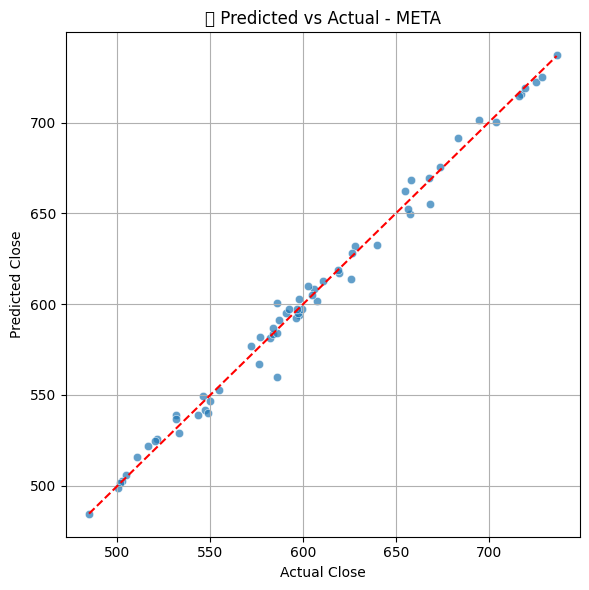


📈 Processing GOOG...


<ipython-input-17-4e39d96088ef>:79: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.



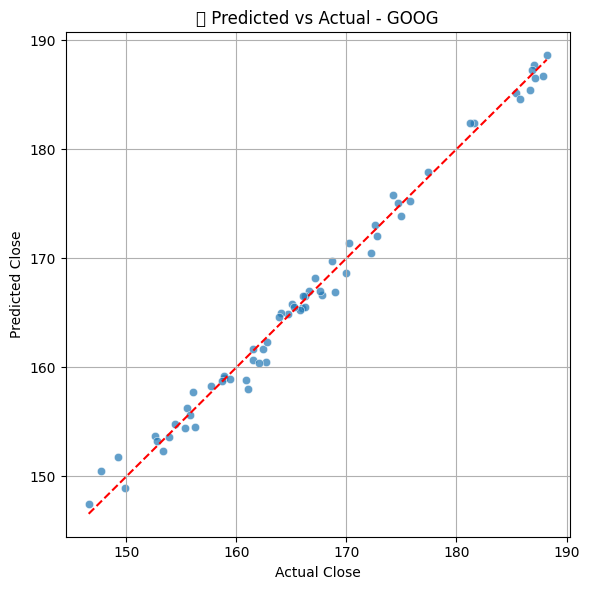


📈 Processing AMZN...


<ipython-input-17-4e39d96088ef>:79: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.



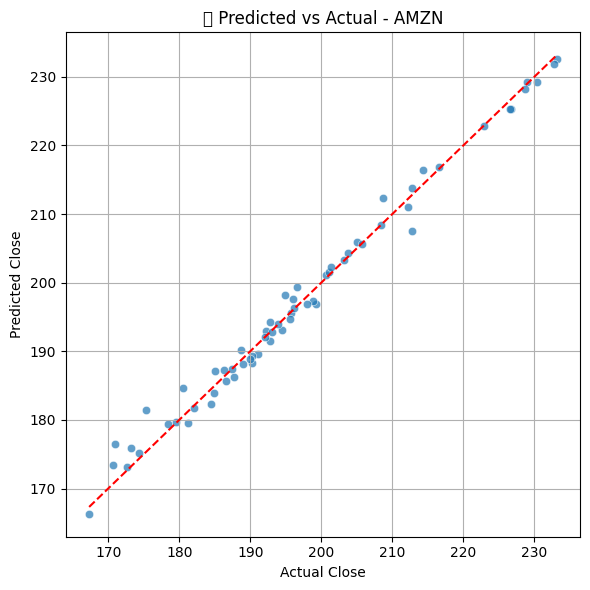

In [17]:
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Stock data and predictions (adjust file names as needed)
stocks = {
    "META": {
        "csv": "META_last_3_months.csv",
        "pred": "META_Predictions_New/part-00000-1d410438-d439-4590-811c-78b36c11e09c-c000.csv"
    },
    "GOOG": {
        "csv": "GOOG_last_3_months.csv",
        "pred": "GOOG_Predictions_New/part-00000-f8b33759-c016-4b76-9905-c3adb2d51b45-c000.csv"
    },
    "AMZN": {
        "csv": "AMZN_last_3_months.csv",
        "pred": "AMZN_Predictions_New/part-00000-16d33f1a-5468-4a7a-9de1-f2f0c93f3d59-c000.csv"
    }
}

for stock, paths in stocks.items():
    print(f"\n📈 Processing {stock}...")

    # --- Candlestick Chart ---
    if os.path.exists(paths["csv"]):
        df = pd.read_csv(paths["csv"])
        df['date'] = pd.to_datetime(df['date'])

        fig = go.Figure()

        fig.add_trace(go.Candlestick(
            x=df['date'],
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            name="Price"
        ))

        fig.add_trace(go.Bar(
            x=df['date'],
            y=df['volume'],
            name='Volume',
            marker_color='lightblue',
            opacity=0.3,
            yaxis='y2'
        ))

        fig.update_layout(
            title=f"{stock} Candlestick with Volume",
            xaxis_title='Date',
            yaxis_title='Price',
            yaxis2=dict(overlaying='y', side='right', title='Volume', showgrid=False),
            xaxis_rangeslider_visible=False,
            height=600
        )

        fig.show()
    else:
        print(f"❌ Missing CSV for {stock}: {paths['csv']}")

    # --- Prediction vs Actual Scatter Plot ---
    if os.path.exists(paths["pred"]):
        pred_df = pd.read_csv(paths["pred"])
        pred_df["prediction"] = pd.to_numeric(pred_df["prediction"], errors="coerce")
        pred_df["Close"] = pd.to_numeric(pred_df["Close"], errors="coerce")
        pred_df = pred_df.dropna(subset=["prediction", "Close"])

        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=pred_df["Close"], y=pred_df["prediction"], alpha=0.7)
        plt.plot([pred_df["Close"].min(), pred_df["Close"].max()],
                 [pred_df["Close"].min(), pred_df["Close"].max()], 'r--')
        plt.xlabel("Actual Close")
        plt.ylabel("Predicted Close")
        plt.title(f"📍 Predicted vs Actual - {stock}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"❌ Missing prediction file for {stock}: {paths['pred']}")
